In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [ ]:
def bscall(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return S*norm.cdf(d1)-K*np.exp(-r*T)*norm.cdf(d2)
    
def bsput(S, K, T, r, sig):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*T)/(sig*np.sqrt(T))
    d2 = (np.log(S/K)+(r-0.5*sig**2)*T)/(sig*np.sqrt(T))
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*norm.cdf(-d1)

In [ ]:
S0 = 1
K1, K2, K3, K4 = 0.85, 0.95, 1.05, 1.15
T = 30/365
r = 0.0
sig = 0.2

M = 1000
N = 30

dt = T/N
rdt = r*dt
sigsdt = sig * np.sqrt(dt)

In [ ]:
np.random.seed(1234)

S = np.empty([M,N+1])
rv = np.random.normal(r*dt,sigsdt,[M,N])

for i in range(M):
    S[i,0] = S0
    for j in range(N):
        S[i,j+1] = S[i,j] * (1+rv[i,j])

In [ ]:
def delta_model(model_name=None):
    price = tf.keras.layers.Input(shape=(1,))
    
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(price)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.BatchNormalization()(delta)
    delta = tf.keras.layers.Dense(32, activation='leaky_relu', use_bias=False)(delta)
    delta = tf.keras.layers.Dense(1, activation='tanh')(delta)

    return tf.keras.Model(inputs=price, outputs=delta, name=model_name)

In [ ]:
price = tf.keras.layers.Input(shape=(1,), name="price")

my_input = [price]

hedge_cost = tf.keras.layers.Lambda(lambda x: x*0.0)(price)

for j in range(N):
    delta = delta_model(model_name="delta_"+str(j))(price)

    new_price = tf.keras.layers.Input(shape=(1,), name='S'+str(j+1))
    my_input += [new_price]

    price_inc = tf.keras.layers.Subtract(name='price_inc_'+str(j))([price, new_price])
    cost = tf.keras.layers.Multiply(name="stock_"+str(j))([delta, price_inc])
    hedge_cost = tf.keras.layers.Add(name='cost_'+str(j))([hedge_cost, cost])

    price = new_price

payoff = tf.keras.layers.Input(shape=(1,), name='payoff')
my_input += [payoff]

cum_cost = tf.keras.layers.Add(name="hedge_cost_plus_payoff")([hedge_cost, payoff])

model = tf.keras.Model(inputs=my_input, outputs=cum_cost)


In [ ]:
SS = [S[:,i].reshape(M,1) for i in range(N+1)]
# payoff = np.maximum(-S[:,-1]+K1, 0) + np.maximum(S[:,-1]-K2, 0) # long strangle
# payoff = np.maximum(S[:,-1]-K1, 0) - 2*np.maximum(S[:,-1]-K2, 0) + np.maximum(S[:,-1]-K3, 0) # long call butterfly
# payoff = np.maximum(K1-S[:,-1], 0) - np.maximum(K2-S[:,-1], 0) # bear put
payoff = np.maximum(S[:,-1]-K1, 0) - np.maximum(S[:,-1]-K2, 0) - np.maximum(K3-S[:,-1], 0) + np.maximum(K4-S[:,-1], 0) # iron condor
x = [SS] + [payoff]
# y = (bsput(S0, K1, T, r, sig) + bscall(S0, K2, T, r, sig)) * np.ones([M,1]) # long strangle
# y = (bscall(S0, K1, T, r, sig) - 2*bscall(S0, K2, T, r, sig) + bscall(S0, K3, T, r, sig)) * np.ones([M,1]) # long call butterfly
# y= (bsput(S0, K2, T, r, sig) - bsput(S0, K1, T, r, sig)) * np.ones([M,1]) # bear put
y = (bscall(S0, K1, T, r, sig) - bscall(S0 ,K2, T, r, sig) - bsput(S0, K3, T, r, sig) + bsput(S0, K4, T, r, sig)) * np.ones([M,1]) # iron condor

In [ ]:
model.compile(loss='mse', optimizer='adam')

In [ ]:
hist = model.fit(x,y, batch_size=32, epochs=200, verbose=True, validation_split=0.2, shuffle=True)

Epoch 1/200
25/25 [==============================] - 16s 95ms/step - loss: 5.8535e-04 - val_loss: 3.8030e-04
Epoch 2/200
25/25 [==============================] - 1s 24ms/step - loss: 1.3394e-04 - val_loss: 3.6332e-04
Epoch 3/200
25/25 [==============================] - 1s 24ms/step - loss: 1.2303e-04 - val_loss: 3.5895e-04
Epoch 4/200
25/25 [==============================] - 1s 24ms/step - loss: 7.5582e-05 - val_loss: 3.5664e-04
Epoch 5/200
25/25 [==============================] - 1s 25ms/step - loss: 6.7820e-05 - val_loss: 3.5424e-04
Epoch 6/200
25/25 [==============================] - 1s 25ms/step - loss: 7.0362e-05 - val_loss: 3.5103e-04
Epoch 7/200
25/25 [==============================] - 1s 24ms/step - loss: 7.6260e-05 - val_loss: 3.3973e-04
Epoch 8/200
25/25 [==============================] - 1s 24ms/step - loss: 6.8049e-05 - val_loss: 3.4473e-04
Epoch 9/200
25/25 [==============================] - 1s 25ms/step - loss: 6.6462e-05 - val_loss: 3.4022e-04
Epoch 10/200
25/25 [=======

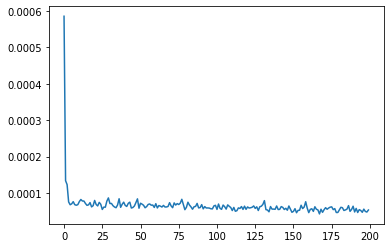

In [ ]:
plt.plot(hist.history['loss'])
plt.show()

In [ ]:
yhat = model.predict(x)

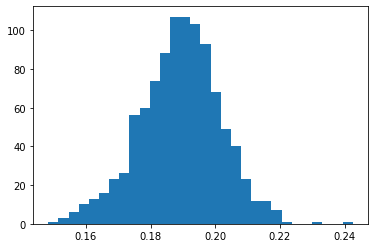

In [ ]:
plt.hist(yhat, bins=30); plt.show()

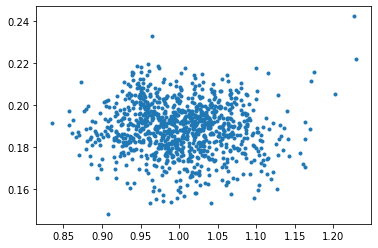

In [ ]:
plt.plot(S[:,-1], yhat, marker='.', linestyle='none'); plt.show()